# Document Search Engine

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import operator
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer



In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Data loading

In [ ]:
news = pd.read_json('https://raw.githubusercontent.com/zayedrais/DocumentSearchEngine/master/data/newsgroups.json')


In [ ]:
news

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4,comp.sys.mac.hardware
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics


### Document Subject retrieving form data

In [ ]:
for i,txt in enumerate(news['content']):
    #print(i)
    subject = re.findall('Subject:(.*\n)',txt)
    if (len(subject) !=0):
        news.loc[i,'Subject'] =str(i)+' '+subject[0]
    else:
        news.loc[i,'Subject'] ='NA'

In [ ]:
df_news =news[['Subject','content']]

In [ ]:
df_news

,Subject,content
0,0 WHAT car is this!?\n,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,1 SI Clock Poll - Final Call\n,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,2 PB questions...\n,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,3 Re: Weitek P9000 ?\n,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,4 Re: Shuttle Launch Question\n,From: jcm@head-cfa.harvard.edu (Jonathan McDow...
...,...,...
11309,11309 Re: Migraines and scans\n,From: jim.zisfein@factory.com (Jim Zisfein) \n...
11310,11310 Screen Death: Mac Plus/512\n,From: ebodin@pearl.tufts.edu\nSubject: Screen ...
11311,11311 Mounting CPU Cooler in vertical case\n,From: westes@netcom.com (Will Estes)\nSubject:...
11312,11312 Re: Sphere from 4 points?\n,From: steve@hcrlgw (Steven Collins)\nSubject: ...


## Data Cleaning and Pre-processing

In [ ]:
# Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
df_news['content']=[entry.lower() for entry in df_news['content']]

<ipython-input-9-db8560035e47>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['content']=[entry.lower() for entry in df_news['content']]


In [ ]:
SW=['subject:','organization:','thanks','thank','re:']

In [ ]:
for sw in SW:
    df_news.content=df_news.content.replace(to_replace=sw,value='',regex=True)

<ipython-input-11-e06027679e79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news.content=df_news.content.replace(to_replace=sw,value='',regex=True)


In [ ]:
df_news

,Subject,content
0,0 WHAT car is this!?\n,from: lerxst@wam.umd.edu (where's my thing)\n ...
1,1 SI Clock Poll - Final Call\n,from: guykuo@carson.u.washington.edu (guy kuo)...
2,2 PB questions...\n,from: twillis@ec.ecn.purdue.edu (thomas e will...
3,3 Re: Weitek P9000 ?\n,from: jgreen@amber (joe green)\n weitek p9000...
4,4 Re: Shuttle Launch Question\n,from: jcm@head-cfa.harvard.edu (jonathan mcdow...
...,...,...
11309,11309 Re: Migraines and scans\n,from: jim.zisfein@factory.com (jim zisfein) \n...
11310,11310 Screen Death: Mac Plus/512\n,from: ebodin@pearl.tufts.edu\n screen death: m...
11311,11311 Mounting CPU Cooler in vertical case\n,from: westes@netcom.com (will estes)\n mountin...
11312,11312 Re: Sphere from 4 points?\n,from: steve@hcrlgw (steven collins)\n sphere ...


In [ ]:
## data Cleaning for content data of news
df_news.content =df_news.content.replace(to_replace='from:(.*\n)',value='',regex=True) #remove from to email
df_news.content =df_news.content.replace(to_replace='lines:(.*\n)',value='',regex=True)
df_news.content =df_news.content.replace(to_replace='[!"#$%&\'()*+,/:;<=>?@[\\]^_`{|}~]',value=' ',regex=True) #remove punctuation except
df_news.content =df_news.content.replace(to_replace='-',value=' ',regex=True)
df_news.content =df_news.content.replace(to_replace='\s+',value=' ',regex=True)    #remove new line
df_news.content =df_news.content.replace(to_replace='  ',value='',regex=True)                #remove double white space
df_news.content =df_news.content.apply(lambda x:x.strip())  # Ltrim and Rtrim of whitespace

<ipython-input-13-13e066793527>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news.content =df_news.content.replace(to_replace='from:(.*\n)',value='',regex=True) #remove from to email
<ipython-input-13-13e066793527>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news.content =df_news.content.replace(to_replace='lines:(.*\n)',value='',regex=True)
<ipython-input-13-13e066793527>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [ ]:
## data cleaning for subject data
df_news.Subject =df_news.Subject.replace(to_replace='Re:',value='',regex=True)
df_news.Subject =df_news.Subject.replace(to_replace='[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',value=' ',regex=True)
df_news.Subject =df_news.Subject.replace(to_replace='\s+',value=' ',regex=True)    #remove new line
df_news.Subject =df_news.Subject.replace(to_replace='  ',value='',regex=True)    #remove double white space
df_news.Subject =df_news.Subject.apply(lambda x:x.strip())

<ipython-input-14-ba0221803b6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news.Subject =df_news.Subject.replace(to_replace='Re:',value='',regex=True)
<ipython-input-14-ba0221803b6b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news.Subject =df_news.Subject.replace(to_replace='[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',value=' ',regex=True)
<ipython-input-14-ba0221803b6b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

### Checking  and dropempty data rows

In [ ]:
## ## Checking  and drop empty data
for i,sen in enumerate(df_news.content):
    if len(sen.strip()) ==0:
        print(str(i))
        #file_data.text[i] = np.nan
        df_news=df_news.drop(str(i),axis=0).reset_index().drop('index',axis=1)

### Word Tokenization

In [ ]:
# okenization : In this each entry in the file_data will be broken into set of words
df_news['Word tokenize']= [word_tokenize(entry) for entry in df_news.content]

<ipython-input-16-4b719d01c813>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['Word tokenize']= [word_tokenize(entry) for entry in df_news.content]


In [ ]:
df_news['Word tokenize']

0        [what, car, is, this, nntp, posting, host, rac...
1        [si, clock, poll, final, call, summary, final,...
2        [pb, questions, ..., purdue, university, engin...
3        [weitek, p9000, harris, computer, systems, div...
4        [shuttle, launch, question, smithsonian, astro...
                               ...                        
11309    [migraines, and, scans, distribution, world, i...
11310    [screen, death, mac, plus, 512, tufts, univers...
11311    [mounting, cpu, cooler, in, vertical, case, ma...
11312    [sphere, from, 4, points, central, research, l...
11313    [stolen, cbr900rr, california, institute, of, ...
Name: Word tokenize, Length: 11314, dtype: object

### Word Lemmatization

In [ ]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
def wordLemmatizer(data):
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    file_clean_k =pd.DataFrame()
    #print(tag_map)
    for index,entry in enumerate(data):

        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        #print("word_Lemmatized",word_Lemmatized)
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            #print("pos_tag(entry)",pos_tag(entry))
            # Below condition is to check for Stop words and consider only alphabets
            if len(word)>1 and word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                #print("word_Final",word_Final)
                Final_words.append(word_Final)
                # The final processed set of words for each iteration will be stored in 'text_final'
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words)
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words)
                #print("file_clean_k",file_clean_k)

    return file_clean_k

In [ ]:
df_news.shape

(11314, 3)

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
## This Function took around 13 hours for word Lemmatized and remove the Stop words & single character of word of each 11314 rows.
df_clean = wordLemmatizer(df_news['Word tokenize'])
df_clean

,Keyword_final
0,"['car', 'nntp', 'post', 'host', 'university', ..."
1,"['si', 'clock', 'poll', 'final', 'call', 'summ..."
2,"['pb', 'question', 'purdue', 'university', 'en..."
3,"['weitek', 'harris', 'computer', 'system', 'di..."
4,"['shuttle', 'launch', 'question', 'smithsonian..."
...,...
11309,"['migraine', 'scan', 'distribution', 'world', ..."
11310,"['screen', 'death', 'mac', 'plus', 'tuft', 'un..."
11311,"['mount', 'cpu', 'cooler', 'vertical', 'case',..."
11312,"['sphere', 'point', 'central', 'research', 'la..."


In [ ]:
# Remove '[' and '.' characters from df_clean
df_clean = df_clean.replace(to_replace="\[.", value='', regex=True)

# Remove "'" character from df_clean
df_clean = df_clean.replace(to_replace="'", value='', regex=True)

# Remove whitespace from df_clean
df_clean = df_clean.replace(to_replace=" ", value='', regex=True)

# Remove ']' character from df_clean
df_clean = df_clean.replace(to_replace='\]', value='', regex=True)

In [ ]:
df_clean

,Keyword_final
0,"car,nntp,post,host,university,maryland,college..."
1,"si,clock,poll,final,call,summary,final,call,si..."
2,"pb,question,purdue,university,engineering,comp..."
3,"weitek,harris,computer,system,division,distrib..."
4,"shuttle,launch,question,smithsonian,astrophysi..."
...,...
11309,"migraine,scan,distribution,world,invention,fac..."
11310,"screen,death,mac,plus,tuft,university,medford,..."
11311,"mount,cpu,cooler,vertical,case,mail,group,news..."
11312,"sphere,point,central,research,lab,hitachi,nntp..."


### Added WordLemmatize words into given dataframe

In [ ]:
## Insert New column in df_news to stored the Clean Keyword
df_news.insert(loc=3, column='Clean_Keyword', value=df_clean['Keyword_final'].tolist())

In [ ]:
df_news

,Subject,content,Word tokenize,Clean_Keyword
0,0 WHAT car is this,what car is this nntp posting host rac3.wam.um...,"[what, car, is, this, nntp, posting, host, rac...","car,nntp,post,host,university,maryland,college..."
1,1 SI Clock Poll Final Call,si clock poll final call summary final call fo...,"[si, clock, poll, final, call, summary, final,...","si,clock,poll,final,call,summary,final,call,si..."
2,2 PB questions,pb questions... purdue university engineering ...,"[pb, questions, ..., purdue, university, engin...","pb,question,purdue,university,engineering,comp..."
3,3 Weitek P9000,weitek p9000 harris computer systems division ...,"[weitek, p9000, harris, computer, systems, div...","weitek,harris,computer,system,division,distrib..."
4,4 Shuttle Launch Question,shuttle launch question smithsonian astrophysi...,"[shuttle, launch, question, smithsonian, astro...","shuttle,launch,question,smithsonian,astrophysi..."
...,...,...,...,...
11309,11309 Migraines and scans,migraines and scans distribution world inventi...,"[migraines, and, scans, distribution, world, i...","migraine,scan,distribution,world,invention,fac..."
11310,11310 Screen Death Mac Plus 512,screen death mac plus 512 tufts university med...,"[screen, death, mac, plus, 512, tufts, univers...","screen,death,mac,plus,tuft,university,medford,..."
11311,11311 Mounting CPU Cooler in vertical case,mounting cpu cooler in vertical case mail grou...,"[mounting, cpu, cooler, in, vertical, case, ma...","mount,cpu,cooler,vertical,case,mail,group,news..."
11312,11312 Sphere from 4 points,sphere from 4 points central research lab. hit...,"[sphere, from, 4, points, central, research, l...","sphere,point,central,research,lab,hitachi,nntp..."


In [ ]:
df_news_save= df_news
df_news_save = df_news_save.drop(['Word tokenize','Clean_Keyword'],axis=1)
df_news_save

,Subject,content
0,0 WHAT car is this,what car is this nntp posting host rac3.wam.um...
1,1 SI Clock Poll Final Call,si clock poll final call summary final call fo...
2,2 PB questions,pb questions... purdue university engineering ...
3,3 Weitek P9000,weitek p9000 harris computer systems division ...
4,4 Shuttle Launch Question,shuttle launch question smithsonian astrophysi...
...,...,...
11309,11309 Migraines and scans,migraines and scans distribution world inventi...
11310,11310 Screen Death Mac Plus 512,screen death mac plus 512 tufts university med...
11311,11311 Mounting CPU Cooler in vertical case,mounting cpu cooler in vertical case mail grou...
11312,11312 Sphere from 4 points,sphere from 4 points central research lab. hit...


In [ ]:
df_news_save.to_csv("df_news_index.csv", index=False, header=True)

In [ ]:
#df_news =pd.read_csv("df_news.csv")

In [ ]:
## Sample of clean keywords
df_news.Clean_Keyword[0]

'car,nntp,post,host,university,maryland,college,park,wonder,anyone,could,enlighten,car,saw,day,door,sport,car,look,late,early,call,bricklin,door,really,small,addition,front,bumper,separate,rest,body,know,anyone,tellme,model,name,engine,spec,year,production,car,make,history,whatever,info,funky,look,car,please,mail,il,bring,neighborhood,lerxst'

# 1. Create document search engine with TF-IDF

### TF-IDF by using  TfidfVectorizer from sklearn.feature_extraction.text

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import operator

## Create Vocabulary
vocabulary = set()

for doc in df_news.Clean_Keyword:
    vocabulary.update(doc.split(','))

vocabulary = list(vocabulary)
print(vocabulary)
# Intializating the tfIdf model
tfidf = TfidfVectorizer(vocabulary=vocabulary,dtype=np.float32)

# Fit the TfIdf model
tfidf.fit(df_news.Clean_Keyword)

# Transform the TfIdf model
tfidf_tran=tfidf.transform(df_news.Clean_Keyword)


['polled', 'belongs', 'irreverent', 'emerald', 'studied', 'fern', 'nevertheless', 'maximus', 'schismatic', 'verbosa', 'pitiful', 'faulty', 'arguing', 'myriad', 'transjordan', 'overt', 'affedin', 'semifinal', 'slovan', 'urquidez', 'bundy', 'periferals', 'talmud', 'nitpicks', 'frysinger', 'jeffh', 'iyb', 'xgs', 'twillis', 'misled', 'cyrus', 'abcdef', 'daul', 'ygd', 'christy', 'bmk', 'rundown', 'incompetency', 'enginering', 'trample', 'poer', 'different', 'sward', 'unresurrected', 'dulles', 'khx', 'vwl', 'inclucing', 'suffocation', 'wgp', 'kqod', 'oncoming', 'dennon', 'bipedally', 'gbeb', 'ycj', 'launching', 'duliyan', 'terminology', 'turned', 'cohort', 'trintex', 'studeman', 'unsent', 'overwhelm', 'screwup', 'fascism', 'enc', 'honor', 'reinstall', 'jection', 'excludes', 'holcomb', 'fstat', 'neuro', 'eventuate', 'formwidgetclass', 'iannamico', 'pole', 'buddhih', 'mcmchael', 'bjorn', 'scamming', 'erie', 'delysid', 'bryn', 'xenophobe', 'caen', 'leveque', 'sedona', 'nahiye', 'wealthy', 'khai

In [ ]:
vocabulary[0:4]

['polled', 'belongs', 'irreverent', 'emerald']

### Save Trained TFID Model

In [ ]:
### Save model
with open('tfid.pkl','wb') as handle:
    pickle.dump(tfidf_tran, handle)

In [ ]:
### load model
t = pickle.load(open('tfid.pkl','rb'))

### Save Vacabulary


In [ ]:
### Save Vacabulary
with open("vocabulary_news20group.txt", "w") as file:
    file.write(str(vocabulary))

In [ ]:
### load Vacabulary
with open("vocabulary_news20group.txt", "r") as file:
    data2 = eval(file.readline())

In [ ]:
data2

['polled',
 'belongs',
 'irreverent',
 'emerald',
 'studied',
 'fern',
 'nevertheless',
 'maximus',
 'schismatic',
 'verbosa',
 'pitiful',
 'faulty',
 'arguing',
 'myriad',
 'transjordan',
 'overt',
 'affedin',
 'semifinal',
 'slovan',
 'urquidez',
 'bundy',
 'periferals',
 'talmud',
 'nitpicks',
 'frysinger',
 'jeffh',
 'iyb',
 'xgs',
 'twillis',
 'misled',
 'cyrus',
 'abcdef',
 'daul',
 'ygd',
 'christy',
 'bmk',
 'rundown',
 'incompetency',
 'enginering',
 'trample',
 'poer',
 'different',
 'sward',
 'unresurrected',
 'dulles',
 'khx',
 'vwl',
 'inclucing',
 'suffocation',
 'wgp',
 'kqod',
 'oncoming',
 'dennon',
 'bipedally',
 'gbeb',
 'ycj',
 'launching',
 'duliyan',
 'terminology',
 'turned',
 'cohort',
 'trintex',
 'studeman',
 'unsent',
 'overwhelm',
 'screwup',
 'fascism',
 'enc',
 'honor',
 'reinstall',
 'jection',
 'excludes',
 'holcomb',
 'fstat',
 'neuro',
 'eventuate',
 'formwidgetclass',
 'iannamico',
 'pole',
 'buddhih',
 'mcmchael',
 'bjorn',
 'scamming',
 'erie',
 'de

### Create vector for Query/search keywords

In [ ]:
## Create vector for Query/search keywords
def gen_vector_T(tokens):
    """
    Generate a TF-IDF vector for the query/search keywords.

    Args:
        tokens (list): List of tokens.

    Returns:
        numpy.ndarray: TF-IDF vector for the query/search keywords.
    """
    Q = np.zeros((len(vocabulary)))

    x = tfidf.transform(tokens)
    for token in tokens[0].split(','):
        try:
            ind = vocabulary.index(token)
            Q[ind] = x[0, tfidf.vocabulary_[token]]
        except:
            pass
    return Q

### Calculate Cosine Similarity with formula

In [ ]:
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

### Calculate Cosine similarity of trained Tfidf to input query

In [ ]:
def cosine_similarity_T(k, query):
    """
    Compute cosine similarity between a query and documents using TF-IDF vectors.

    Args:
        k (int): Number of top documents to retrieve.
        query (str): Query string.

    Returns:
        pandas.DataFrame: DataFrame containing the top k documents with their corresponding similarity scores.
    """
    # print("Cosine Similarity")
    
    # preprocess the query string by removing non-word characters and stripping whitespace
    preprocessed_query = re.sub("\W+", " ", query).strip()

    # tokenize the query string and convert the tokens to lemmatized words
    tokens = word_tokenize(str(preprocessed_query))

    q_df = pd.DataFrame(columns=['q_clean'])
    q_df.loc[0, 'q_clean'] = tokens
    q_df['q_clean'] = wordLemmatizer(q_df.q_clean)
    q_df = q_df.replace(to_replace="\[.", value='', regex=True)
    q_df = q_df.replace(to_replace="'", value='', regex=True)
    q_df = q_df.replace(to_replace=" ", value='', regex=True)
    q_df = q_df.replace(to_replace='\]', value='', regex=True)
    # print("\nQuery:", query)
    # print("")
    # print(tokens)

    d_cosines = []
    # Generate a TF-IDF vector for the query string
    query_vector = gen_vector_T(q_df['q_clean'])
    # Iterate over the TF-IDF vectors for all of the documents in the corpus
    for d in tfidf_tran.A:
        d_cosines.append(cosine_sim(query_vector, d))

    out = np.array(d_cosines).argsort()[-k:][::-1]
    # print("")
    d_cosines.sort()
    # print(out)
    a = pd.DataFrame()
    for i, index in enumerate(out):
        a.loc[i, 'index'] = str(index)
        a.loc[i, 'Subject'] = df_news['Subject'][index]
    for j, simScore in enumerate(d_cosines[-k:][::-1]):
        a.loc[j, 'Score'] = simScore
    return a

In [ ]:
%time cosine_similarity_T(10,'computer science')
#df_news['Subject']

CPU times: user 2.49 s, sys: 3.19 s, total: 5.68 s
Wall time: 3.74 s


,index,Subject,Score
0,2231,2231 Computer Engr vs Computer Science,0.406677
1,10340,10340 Science and Methodology,0.297963
2,7618,7618 Solution Why do I need xrdb m when Xdefau...,0.288364
3,4326,4326 Computer Engr vs Computer Science,0.287809
4,4173,4173 Rawlins debunks creationism,0.286056
5,6921,6921 Automatic layout of state diagrams,0.272498
6,929,929 Maxtor drive geometry jumpers,0.251504
7,8464,8464 Date is stuck,0.250044
8,5741,5741 Rawlins debunks creationism,0.244043
9,784,784 Objective Values v Scientific Accuracy was...,0.241720


In [ ]:
df_news.content[2231]

'computer engr vs. computer science distribution usa ncr microelectronics products division an at t company in article 1993apr10.210242.340 macadam.com mike macadam.com writes i am a freshman in college and can t decide whether to major in computer engineering or computer science. any advice or suggestions will be appreciated. mike a professor of mine once said the difference between a computer engineer and a computer scientist is about 5000 meaning the engineer makes 5000 more than the cs. seriously though the main difference is that most cs people write programs that people will use i.e. database graphics word processors etc. while an engineer writes for machines or control systems i.e. the computer in your car a flight control system computer controled devices etc. in other words cs writes software while cse writes firmware. these are generalizations but for the most part that is what the difference is. p.s. the 5000 is not just a joke scott'

# 2. Document Search Engine with Google Universal Sentence Encoder

In [ ]:
!pip install --upgrade tensorflow-gpu
#Install TF-Hub.
!pip install tensorflow-hub
!pip install seaborn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
import numpy as np
import re, string
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.13.0
Eager mode:  True
Hub version:  0.15.0
GPU is available


### Load Google Universal sentence Encoder(DAN) Pretrained model

In [ ]:
!tar -xf 4.tar.gz

tar: 4.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
!mkdir /home/zettadevs/GoogleUSE Model
! curl -L -o 4.tar.gz "https://tfhub.dev/google/universal-sentence-encoder/4?tf-hub-format=compressed"


mkdir: cannot create directory ‘/home/zettadevs/GoogleUSE’: No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  915M  100  915M    0     0  20.5M      0  0:00:44  0:00:44 --:--:-- 21.0M


In [ ]:
#!mkdir /home/zettadevs/GoogleUSE Model
#! curl -L -o 4.tar.gz "https://tfhub.dev/google/universal-sentence-encoder/4?tf-hub-format=compressed"
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
module_path ="/content/4.tar.gz"
%time model = hub.load(module_url)
#print ("module %s loaded" % module_url)

#Create function for using modeltraining
def embed(input):
    return model(input)

CPU times: user 12.1 s, sys: 3.05 s, total: 15.2 s
Wall time: 50.5 s


### Use Case of Google USE

In [ ]:
def plot_similarity(labels, features, rotation):
    """
    Plot the semantic similarity between labels based on their features.

    Args:
        labels (list): List of labels.
        features (numpy.ndarray): Array of features.
        rotation (float): Rotation angle for x-axis labels.

    Returns:
        None
    """
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Similarity")

In [ ]:
def run_and_plot_U(messages_):
    """
    Run the embedding model on the given messages and plot the semantic similarity.

    Args:
        messages_ (list): List of messages.

    Returns:
        None
    """
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)

### Use Case 1:- Word semantic

In [ ]:
WordMessage =['big data', 'millions of data', 'millions of records','cloud computing','aws','azure','saas','bank','account']

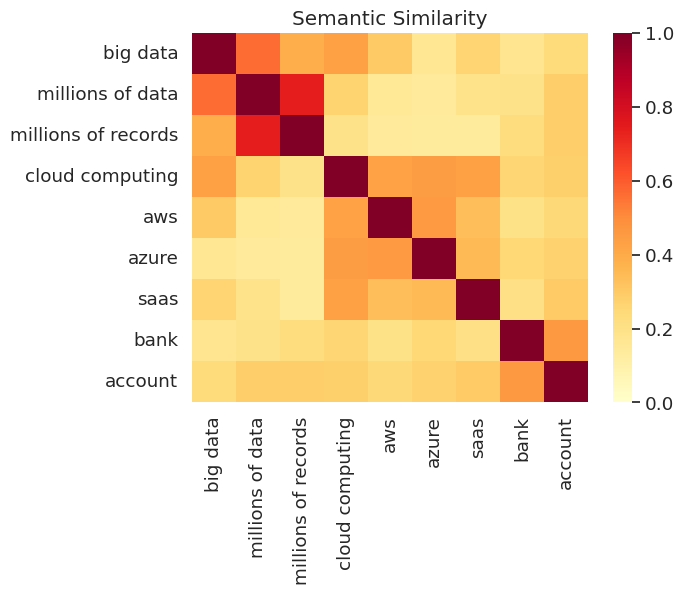

In [ ]:
run_and_plot_U(WordMessage)  # here 'big data' and 'millions od data' it's correlated score is between 0.6 to 0.5.
                            # Even 'AWS' and 'Azure' are also b/w 0.6 to 0.5. As you can see below pic

### Use Case 2: Sentence Semantic

In [ ]:
SentMessage =['How old are you?','what is your age?','how are you?','how you doing?']

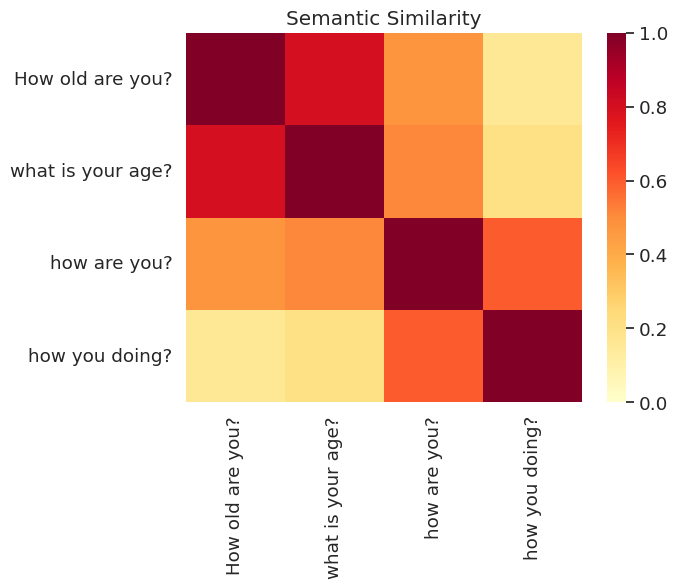

In [ ]:
run_and_plot_U(SentMessage)

In [ ]:
len(df_news.content)

11314

## Training the google use model batch wise chunk size 1000 rows

In [ ]:
# Create a list of chunk sizes, where each chunk size is 1000 or less, such that the sum of the chunk sizes is equal to the length of the dataset.
ls = []
chunksize = 1000
le = len(df_news.content)
for i in range(0, le, chunksize):
    if i + chunksize > le:
        chunksize = le
        ls.append(chunksize)
    else:
        a = i + chunksize
        ls.append(a)

print(ls)

j = 0

# Iterate over the list of chunk sizes.
for i in ls:

    # Create a directory to store the SavedModel file.
    directory = "GoogleUSEModel/TrainModel/" + str(i)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Compute the embeddings for the news articles in the current chunk.
    m = embed(df_news.content[j:i])

    # Create a TensorFlow Checkpoint object to save the embeddings.
    exported_m = tf.train.Checkpoint(v=tf.Variable(m))

    # Create a TensorFlow function that multiplies the embeddings by a given input.
    exported_m.f = tf.function(
        lambda x: exported_m.v * x,
        input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)]
    )

    # Save the TensorFlow function to a SavedModel file in the current directory.
    tf.saved_model.save(exported_m, directory)

    # Update the index to the next chunk size.
    j = i

    # Print the current chunk size.
    print(i)


0 1000
1000
1000 2000
2000
2000 3000
3000
3000 4000
4000
4000 5000
5000
5000 6000
6000
6000 7000
7000
7000 8000
8000
8000 9000
9000
9000 10000
10000
10000 11000
11000
11000 11314
11314


##  Batch wise Load the model

In [ ]:
# Create a list to store the loaded embeddings.
ar = []

# Iterate over the list of chunk sizes.
for i in ls:

    # Create a directory path to the SavedModel file.
    directory = "GoogleUSEModel/TrainModel/" + str(i)

    # Check if the SavedModel file exists.
    if os.path.exists(directory):

        # Print the directory path.
        print(directory)

        # Load the SavedModel file.
        imported_m = tf.saved_model.load(directory)

        # Get the embeddings from the SavedModel file.
        a = imported_m.v.numpy()

        # Print the embeddings.
        print(a)

        # Create a global variable to store the embeddings for the current chunk.
        exec(f'load{i} = a')



GoogleUSEModel/TrainModel/1000
[[-0.06216156  0.04723303 -0.0445745  ...  0.02865245 -0.00272059
   0.00195009]
 [-0.04221828 -0.06031107 -0.06992399 ... -0.05064002 -0.06219282
   0.02693725]
 [-0.026542   -0.06873067 -0.06372759 ...  0.05727946 -0.05443877
   0.00119262]
 ...
 [ 0.01018366  0.0446233   0.03287495 ...  0.06447926  0.0092233
  -0.00063398]
 [-0.01370367  0.0239017  -0.0031861  ...  0.00115729 -0.06466056
  -0.05321121]
 [-0.05206254 -0.03850227 -0.02466701 ...  0.0474923  -0.04967555
   0.02790056]]
GoogleUSEModel/TrainModel/2000
[[-0.05833615  0.00263705  0.0580814  ...  0.01837341 -0.05166262
  -0.05159397]
 [-0.05133416  0.00601929 -0.03822208 ...  0.04041345  0.02060336
  -0.07195642]
 [-0.03658523 -0.05953107  0.05257141 ...  0.0581208  -0.05506994
   0.05239373]
 ...
 [-0.05569232 -0.05222107  0.01638364 ...  0.0369947  -0.03035719
  -0.07611398]
 [-0.04871823 -0.00901475  0.06376144 ...  0.06170055 -0.01481958
  -0.06321616]
 [-0.04632014 -0.02895666 -0.04553659

## Concatenate the array from batchwise loaded model

In [ ]:
con_a =np.concatenate((load1000, load2000,load3000,load4000,load5000,load6000,load7000,load8000,load9000,load10000,load11000,load11314))
con_a.shape

(11314, 512)

## Training the model for single time

In [ ]:
## training the model
Model_USE= embed(df_news.content[0:2500])

## Save model for single time

In [ ]:
exported = tf.train.Checkpoint(v=tf.Variable(Model_USE))
exported.f = tf.function(
    lambda  x: exported.v * x,
    input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])

tf.saved_model.save(exported,'GoogleUSEModel/TrainModel')

## Load model for single time

In [ ]:
## Load Model
imported = tf.saved_model.load('GoogleUSEModel/TrainModel/')
loadedmodel =imported.v.numpy()
loadedmodel.shape

(2500, 512)

## Create Function to get the top Similare document by giving input as a keyword or sentence.

In [ ]:
def SearchDocument(query):
    """Searches for documents that are similar to the given query.

    Args:
        query: The query string.

    Returns:
        A Pandas DataFrame containing the top 10 most similar documents, ranked by similarity score.
    """

    # Convert the query string to a list.
    q = [query]

    # Embed the query for calculating the similarity.
    Q_Train = embed(q)

    # Calculate the similarity between the query and all of the documents in the dataset.
    linear_similarities = linear_kernel(Q_Train, con_a).flatten()

    # Sort the top 10 documents by similarity score.
    Top_index_doc = linear_similarities.argsort()[:-11:-1]

    # Sort the similarity scores.
    linear_similarities.sort()

    # Create a Pandas DataFrame to store the results.
    a = pd.DataFrame()

    # Add the document index and file name to the DataFrame.
    for i, index in enumerate(Top_index_doc):
        a.loc[i, 'index'] = index
        a.loc[i, 'File_Name'] = df_news['Subject'][index]

    # Add the similarity score to the DataFrame.
    for j, simScore in enumerate(linear_similarities[:-11:-1]):
        a.loc[j, 'Score'] = simScore

    # Return the DataFrame.
    return a


In [ ]:
SearchDocument('semantic search')

,index,File_Name,Score
0,551,551 Christian s need for Christianity,0.256091
1,5596,5596 Ax the ATF,0.247231
2,6242,6242 WinWord Spelling Dictionaries for non US ...,0.247116
3,5900,5900 Science and methodology was Homeopathy tr...,0.226029
4,4094,4094 Radical Agnostic NOT,0.222487
5,652,652 Building a UV flashlight,0.216888
6,5568,5568 Americans and Evolution,0.213916
7,3003,3003 How do you find a window id given its name,0.213711
8,7184,7184 Ax the ATF,0.213488
9,2533,2533 After 2000 years can we say that Christia...,0.207329


In [74]:
!cp -r /content/df_news_index.csv /content/drive/MyDrive/Cyshield